In [ ]:
!pip install -q kagglehub ultralytics timm matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.7 MB/s eta 0:00:00


In [ ]:
import kagglehub
import os

# Download dataset
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")

# Define proper sub-path
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

# Check path
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")
print(f"✅ Dataset path: {DATASET_PATH}")


100%|██████████| 444M/444M [00:05<00:00, 80.6MB/s]

Extracting files...


✅ Dataset path: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs


Classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']


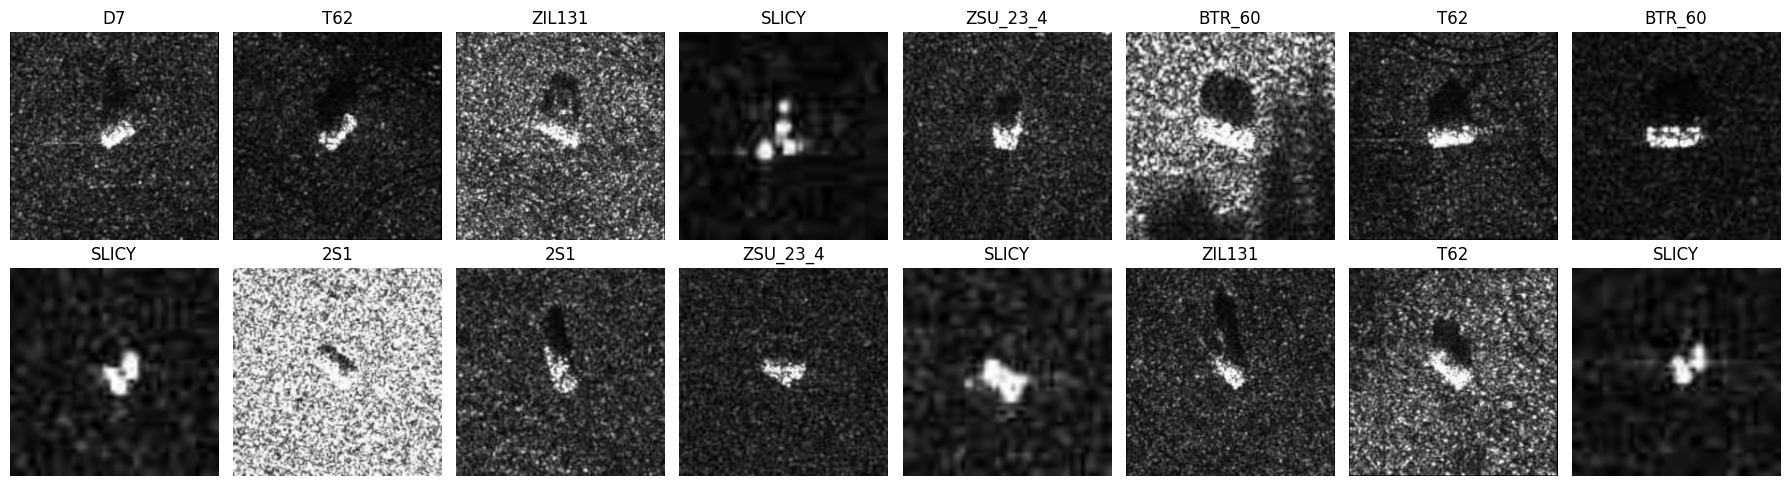

In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

# Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Class names
class_names = dataset.classes
print("Classes:", class_names)

# Show some images
def show_images(images, labels):
    fig, axes = plt.subplots(2, 8, figsize=(18, 5))
    for i, ax in enumerate(axes.flatten()):
        img = images[i].permute(1, 2, 0).squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(dataloader))
show_images(images, labels)


In [ ]:
import torch
import torch.nn as nn
import timm

class SARClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(SARClassifier, self).__init__()
        # Pretrained ResNet50
        self.backbone = timm.create_model("resnet50", pretrained=True)
        self.backbone.fc = nn.Identity()

        # Transformer encoder
        self.attention = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=2048, nhead=8),
            num_layers=1
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)  # [B, 2048]
        feats = feats.unsqueeze(1)  # Add sequence dim: [B, 1, 2048]
        feats = self.attention(feats)  # [B, 1, 2048]
        feats = feats.squeeze(1)  # [B, 2048]
        return self.classifier(feats)

# Check model
model = SARClassifier(num_classes=len(class_names)).to("cuda" if torch.cuda.is_available() else "cpu")
print(model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

SARClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 3  # Start small; increase for better results

model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

print("✅ Training complete.")


Epoch [3/3]: 100%|██████████| 592/592 [1:59:58<00:00, 12.16s/it, acc=97.3, loss=0.00791]

✅ Training complete.


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

print(f"🔍 Final Accuracy: {100. * correct / total:.2f}%")


🔍 Final Accuracy: 98.91%


In [ ]:
!pip install -q ultralytics
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra

In [ ]:
# Load YOLOv8 small model
model_yolo = YOLO('yolov8n.pt')  # replace with 'yolov8s.pt' or your trained model if available

# To fine-tune later: model.train(data='your_data.yaml', epochs=50)


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.0MB/s]


100%|██████████| 444M/444M [00:08<00:00, 53.0MB/s]

Extracting files...


✅ Dataset path: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs


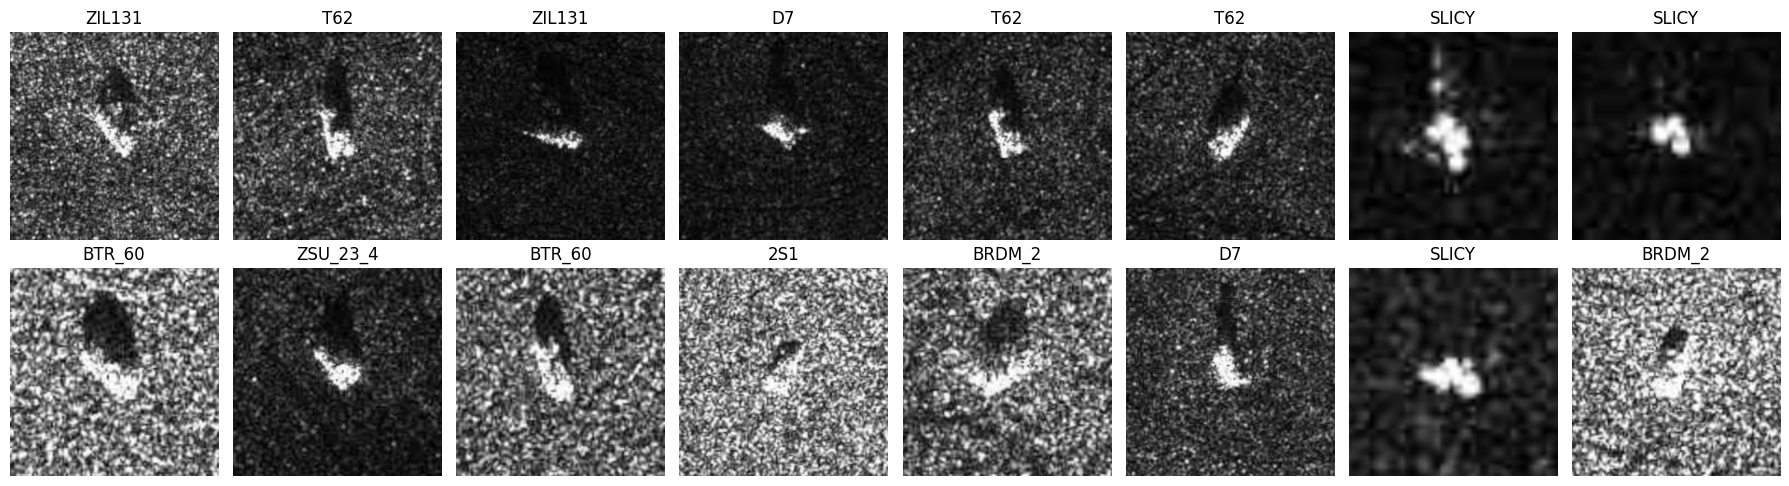

In [4]:
from torchvision import datasets
import torchvision.transforms as T
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
import kagglehub # Import kagglehub
import matplotlib.pyplot as plt # Import matplotlib for plotting

class SARYOLOCropDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root, transform=T.Resize((256, 256)))
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        # YOLO Detection Simulation: return full image as "detected" region
        detected_img = image.crop((16, 16, 240, 240))  # Simulated crop

        if self.transform:
            detected_img = self.transform(detected_img)

        return detected_img, label

# Transforms
transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.ToTensor()
])

# Define DATASET_PATH again
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")
# Define proper sub-path
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")
# Check path
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")
print(f"✅ Dataset path: {DATASET_PATH}")

# Load Dataset with YOLO-style crops
yolo_dataset = SARYOLOCropDataset(DATASET_PATH, transform=transform)
yolo_loader = DataLoader(yolo_dataset, batch_size=16, shuffle=True)

# Class names (assuming you have this defined somewhere)
class_names = yolo_dataset.dataset.classes

# Show some images function
def show_images(images, labels):
    fig, axes = plt.subplots(2, 8, figsize=(18, 5))
    for i, ax in enumerate(axes.flatten()):
        img = images[i].permute(1, 2, 0).squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize cropped
images, labels = next(iter(yolo_loader))
show_images(images, labels)

In [ ]:
# Use same SARClassifier code as before
import torch
from tqdm import tqdm # Import tqdm for progress bar
import torch.nn as nn
import timm # Import timm
from torchvision import datasets # Import datasets for ImageFolder


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SARClassifier (copied from previous cell)
class SARClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(SARClassifier, self).__init__()
        # Pretrained ResNet50
        self.backbone = timm.create_model("resnet50", pretrained=True)
        self.backbone.fc = nn.Identity()

        # Transformer encoder
        self.attention = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=2048, nhead=8),
            num_layers=1
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)  # [B, 2048]
        feats = feats.unsqueeze(1)  # Add sequence dim: [B, 1, 2048]
        feats = self.attention(feats)  # [B, 1, 2048]
        feats = feats.squeeze(1)  # [B, 2048]
        return self.classifier(feats)

# Assuming DATASET_PATH is already defined from a previous cell:
# Load Dataset for getting class names using ImageFolder
dataset = datasets.ImageFolder(DATASET_PATH)
class_names = dataset.classes  # Get class names from the dataset


model = SARClassifier(num_classes=len(class_names)).to(device)

# Optimizer & loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCHS = 3
model.train()
for epoch in range(EPOCHS):
    running_loss = 0
    correct = 0
    total = 0
    loop = tqdm(yolo_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

print("✅ resent dataset classifier training done.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch [1/3]:   8%|▊         | 48/592 [08:25<1:31:39, 10.11s/it, acc=44, loss=0.851]